In [202]:
import torch as torch
import pandas as pd
import numpy as np

In [203]:
# Upload datasets to google colab

from google.colab import files
uploaded = files.upload()

In [204]:
# read in datasets

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [206]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [207]:
def percent_missing(train):
  df = pd.DataFrame(columns=['Feature', 'NaN\'s', 'Percent'])
  for col in train:
    feat = col
    nan = train[col].isna().sum()
    percent = round((nan / len(train[col])) * 100, 2)
    df.loc[len(df.index)] = [feat, nan, percent]
  df = df.sort_values(['Percent'], ascending=False)
  return df

In [208]:
df = percent_missing(train)
df.head(10)

,Feature,NaN's,Percent
72,PoolQC,1453,99.52
74,MiscFeature,1406,96.30
6,Alley,1369,93.77
73,Fence,1179,80.75
57,FireplaceQu,690,47.26
3,LotFrontage,259,17.74
59,GarageYrBlt,81,5.55
64,GarageCond,81,5.55
58,GarageType,81,5.55
60,GarageFinish,81,5.55


In [209]:
def get_corr(train):
  df = train.select_dtypes(exclude=['object'])
  corr = df.corr()
  target_corr = corr['SalePrice']

  corr_df = pd.DataFrame(target_corr, df.columns).sort_values(by="SalePrice", ascending=False)
  return corr_df

In [210]:
get_corr(train)

,SalePrice
SalePrice,1.00
OverallQual,0.79
GrLivArea,0.71
GarageCars,0.64
GarageArea,0.62
TotalBsmtSF,0.61
1stFlrSF,0.61
FullBath,0.56
TotRmsAbvGrd,0.53
YearBuilt,0.52


In [211]:
def unique_vals(train):
  df = pd.DataFrame(columns=['Name', '%unique', '%NaN'])
  m = len(train)
  for col in train:
    sum_na = train[col].isna().sum()
    unique_val_max = train[col].value_counts().sort_values().max()
    if unique_val_max > sum_na:
      if unique_val_max > m * .9:
        percent = round((1 - (unique_val_max / m)) * 100, 2)
        df.loc[len(df.index)] = [col, percent, np.nan]
    else:
      if sum_na > m * .9:
        percent = round((1 - (sum_na / m)) * 100, 2)
        df.loc[len(df.index)] = [col, np.nan, percent]
    df = df.sort_values(['%unique'])
  return df

In [212]:
df = unique_vals(train)

If the dataset is trumped by only 1 feature then it will be ok to drop that feature since it wouldn't have any impact on model performance.

In [213]:
col = (df['%unique'] < 5)
names_to_drop = [df['Name'].loc[i] for i in range(len(df)) if df['%unique'].loc[i] < 5]
names_to_drop = names_to_drop + [df['Name'].loc[i] for i in range(len(df)) if df['%NaN'].loc[i] < 5]
names_to_drop

['Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Heating',
 'LowQualFinSF',
 'KitchenAbvGr',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'PoolQC',
 'MiscFeature']

In [214]:
train_1 = train.drop(names_to_drop, axis=1)
test_1 = test.drop(names_to_drop, axis=1)

In [216]:
train_1num = train_1.select_dtypes(exclude=['object'])
test_1num = test_1.select_dtypes(exclude=['object'])

train_1num['LotFrontage'] = train_1num['LotFrontage'].fillna(0)
test_1num['LotFrontage'] = test_1num['LotFrontage'].fillna(0)

train_1num['GarageYrBlt'] = train_1num['GarageYrBlt'].fillna(0)
test_1num['GarageYrBlt'] = test_1num['GarageYrBlt'].fillna(0)

In [217]:
# copy new data after filling in lot frontage and garage year build

train_2 = train_1
test_2 = test_1

train_2[train_1num.columns] = train_1num
test_2[test_1num.columns] = test_1num

In [219]:
train_2.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Alley            1369
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbv

In [220]:
# used to see the difference between each object column to filter out different values in the training and test set

def get_diff_test_train(train, test):
  train_2col = train.select_dtypes(include=['object'])
  test_2col = test.select_dtypes(include=['object'])

  cols_to_engin = []
  for col in train_2col:
    train_unique_1val = pd.DataFrame(train_2col[col].value_counts(dropna=False).reset_index())
    train_unique_val = list(train_unique_1val['index'].unique())

    test_unique_1val = pd.DataFrame(test_2col[col].value_counts(dropna=False).reset_index())
    test_unique_val = list(test_unique_1val['index'].unique())

    shared_vals = set(train_unique_val) & set(test_unique_val)
    unique_in_train = list(set(train_unique_val).difference(shared_vals))
    unique_in_test = list(set(test_unique_val).difference(shared_vals))

    if len(unique_in_train) == 0 and len(unique_in_test) == 0:
      continue
    print(train_unique_1val)
    print(col + '\nunique in train:{}\tunique in test:{}\n\n'.format(unique_in_train, unique_in_test))
    cols_to_engin.append(col)
  return cols_to_engin

In [221]:
# used to see the difference between each integer column to filter out different values in the training and test set

def get_diff_test_train_int(train, test):
  train_2col = train.select_dtypes(exclude=['object'])
  test_2col = test.select_dtypes(exclude=['object'])

  cols_to_engin = []
  for col in train_2col:
    if col == 'SalePrice':
      continue
    train_unique_1val = pd.DataFrame(train_2col[col].value_counts(dropna=False).reset_index())
    train_unique_val = list(train_unique_1val['index'].unique())

    test_unique_1val = pd.DataFrame(test_2col[col].value_counts(dropna=False).reset_index())
    test_unique_val = list(test_unique_1val['index'].unique())

    shared_vals = set(train_unique_val) & set(test_unique_val)
    unique_in_train = list(set(train_unique_val).difference(shared_vals))
    unique_in_test = list(set(test_unique_val).difference(shared_vals))

    if len(unique_in_train) == 0 and len(unique_in_test) == 0:
      continue
    print(train_unique_1val)
    print(col + '\nunique in train:{}\tunique in test:{}\n\n'.format(unique_in_train, unique_in_test))
    cols_to_engin.append(col)
  return cols_to_engin

In [222]:
get_diff_test_train(train_2, test_2)

     index  MSZoning
0       RL      1151
1       RM       218
2       FV        65
3       RH        16
4  C (all)        10
MSZoning
unique in train:[]	unique in test:[nan]


    index  HouseStyle
0  1Story         726
1  2Story         445
2  1.5Fin         154
3    SLvl          65
4  SFoyer          37
5  1.5Unf          14
6  2.5Unf          11
7  2.5Fin           8
HouseStyle
unique in train:['2.5Fin']	unique in test:[]


      index  Exterior1st
0   VinylSd          515
1   HdBoard          222
2   MetalSd          220
3   Wd Sdng          206
4   Plywood          108
5   CemntBd           61
6   BrkFace           50
7   WdShing           26
8    Stucco           25
9   AsbShng           20
10  BrkComm            2
11    Stone            2
12  AsphShn            1
13  ImStucc            1
14   CBlock            1
Exterior1st
unique in train:['ImStucc', 'Stone']	unique in test:[nan]


      index  Exterior2nd
0   VinylSd          504
1   MetalSd          214
2   HdBoard         

['MSZoning',
 'HouseStyle',
 'Exterior1st',
 'Exterior2nd',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageQual',
 'SaleType']

In [224]:
# from above function call manually deal with differences between training and test sets

train_2col = train_2.select_dtypes(include=['object'])
test_2col = test_2.select_dtypes(include=['object'])

test_2col['MSZoning'] = test_2col['MSZoning'].fillna('C (all)')

train_2col['HouseStyle'] = train_2col['HouseStyle'].replace('2.5Fin', '2Story')

train_2col['Exterior1st'] = train_2col['Exterior1st'].replace(['ImStucc', 'Stone'], ['Stucco', 'CemntBd'])
test_2col['Exterior1st'] = test_2col['Exterior1st'].fillna('VinylSd')

test_2col['Exterior2nd'] = test_2col['Exterior2nd'].fillna('Other')

train_2col['Electrical'] = train_2col['Electrical'].replace('Mix', 'SBrkr')
train_2col['Electrical'] = train_2col['Electrical'].fillna('SBrkr')

test_2col['KitchenQual'] = test_2col['KitchenQual'].fillna('TA')

test_2col['Functional'] = test_2col['Functional'].fillna('Typ')

train_2col['GarageQual'] = train_2col['GarageQual'].replace('Ex', 'Gd')

test_2col['SaleType'] = test_2col['SaleType'].fillna('WD')

get_diff_test_train(train_2col, test_2col)

[]

In [225]:
train_3 = train_2
test_3 = test_2

train_3[train_2col.columns] = train_2col
test_3[test_2col.columns] = test_2col

get_diff_test_train(train_3, test_3)

[]

In [227]:
train_3['MasVnrArea'] = train_3['MasVnrArea'].fillna(train_3['MasVnrArea'].median())
test_3['MasVnrArea'] = test_3['MasVnrArea'].fillna(test_3['MasVnrArea'].median())

get_diff_test_train_int(train_3, test_3)

      index  Id
0         1   1
1       982   1
2       980   1
3       979   1
4       978   1
...     ...  ..
1455    485   1
1456    484   1
1457    483   1
1458    482   1
1459   1460   1

[1460 rows x 2 columns]
Id
unique in train:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 1

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch']

In [247]:
pd.set_option('display.max_rows',None)
train_3.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Alley            1369
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbv

In [229]:
# achieved bettwe accuracy when we did not fill na and let make_dummies fill them

# train_3['Alley'] = train_3['Alley'].fillna('No Alley')
# test_3['Alley'] = test_3['Alley'].fillna('No Alley')

# train_3['MasVnrType'] = train_3['MasVnrType'].fillna('No Mas')
# test_3['MasVnrType'] = test_3['MasVnrType'].fillna('No Mas')

# train_3['BsmtQual'] = train_3['BsmtQual'].fillna('No Bsmt')
# test_3['BsmtQual'] = test_3['BsmtQual'].fillna('No Bsmt')

# train_3['BsmtCond'] = train_3['BsmtCond'].fillna('No Bsmt')
# test_3['BsmtCond'] = test_3['BsmtCond'].fillna('No Bsmt')

# train_3['BsmtExposure'] = train_3['BsmtExposure'].fillna('No Bsmt')
# test_3['BsmtExposure'] = test_3['BsmtExposure'].fillna('No Bsmt')

# train_3['BsmtFinType1'] = train_3['BsmtFinType1'].fillna('No Bsmt')
# test_3['BsmtFinType1'] = test_3['BsmtFinType1'].fillna('No Bsmt')

# train_3['BsmtFinType2'] = train_3['BsmtFinType2'].fillna('No Bsmt')
# test_3['BsmtFinType2'] = test_3['BsmtFinType2'].fillna('No Bsmt')

# train_3['FireplaceQu'] = train_3['FireplaceQu'].fillna('No Fireplace')
# test_3['FireplaceQu'] = test_3['FireplaceQu'].fillna('No Fireplace')

# train_3['GarageType'] = train_3['GarageType'].fillna('No Garage')
# test_3['GarageType'] = test_3['GarageType'].fillna('No Garage')

# train_3['GarageFinish'] = train_3['GarageFinish'].fillna('No Garage')
# test_3['GarageFinish'] = test_3['GarageFinish'].fillna('No Garage')

# train_3['GarageQual'] = train_3['GarageQual'].fillna('No Garage')
# test_3['GarageQual'] = test_3['GarageQual'].fillna('No Garage')

# train_3['GarageCond'] = train_3['GarageCond'].fillna('No Garage')
# test_3['GarageCond'] = test_3['GarageCond'].fillna('No Garage')

# train_3['Fence'] = train_3['Fence'].fillna('No Fence')
# test_3['Fence'] = test_3['Fence'].fillna('No Fence')

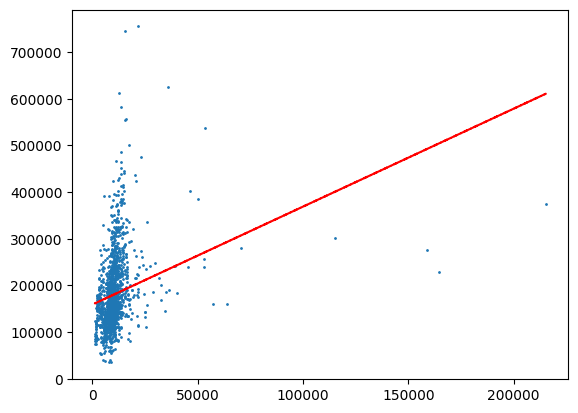

In [231]:
# used to visualize outliers
# for better results I could have dealt with outliers, but I choose not to

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

train_3num = train_3.select_dtypes(exclude=['object'])

x = train_3num['LotArea']
y =train_3num['SalePrice']
plt.scatter(x,y,s=1)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

In [232]:
# used one-hot-encoding for object columns

train_3col = train_3.select_dtypes(include=['object'])
test_3col = test_3.select_dtypes(include=['object'])

one_hot_train = pd.get_dummies(train_3col)
one_hot_test = pd.get_dummies(test_3col)

train_4 = train_3.select_dtypes(exclude=['object']).join(one_hot_train)
test_4 = test_3.select_dtypes(exclude=['object']).join(one_hot_test)

In [233]:
print(train_4.shape)
print(test_4.shape)

(1460, 247)
(1459, 246)


In [234]:
from sklearn.model_selection import train_test_split

y = train_4['SalePrice']
X = train_4.drop(['SalePrice', 'Id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=.2)

print(X_train.shape)
print(y_train.shape)

(1168, 245)
(1168,)


In [235]:
# lazypredict to test a number of regression models quickly

!pip install lazypredict

In [236]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models

 76%|███████▌  | 32/42 [00:16<00:02,  3.36it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


 98%|█████████▊| 41/42 [00:24<00:00,  2.13it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3314
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 176
[LightGBM] [Info] Start training from score 182208.341610


100%|██████████| 42/42 [00:24<00:00,  1.70it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
BaggingRegressor,0.41,0.91,25801.18,0.33
GradientBoostingRegressor,0.33,0.89,27479.89,1.00
HistGradientBoostingRegressor,0.32,0.89,27766.41,2.00
ExtraTreesRegressor,0.29,0.89,28359.95,2.78
RandomForestRegressor,0.28,0.89,28406.18,3.30
PoissonRegressor,0.28,0.89,28498.67,0.10
HuberRegressor,0.26,0.88,28934.42,0.46
GammaRegressor,0.25,0.88,29130.69,0.04
OrthogonalMatchingPursuit,0.24,0.88,29227.00,0.03


In [256]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [262]:
pred = reg.predict(X_test)
rms = mean_squared_error(np.log(y_test), np.log(pred))
np.sqrt(rms)

0.13323377740078074

In [239]:
print(pred[:5])
print(y_test[:5])

[206793.57678981 174180.14139026 116816.48578975  78297.32157322
 142219.81416294]
258     231500
267     179500
288     122000
649      84500
1233    142000
Name: SalePrice, dtype: int64


In [249]:
test_5 = test_4.fillna(0)

In [263]:
test_id = test_5['Id']
test = test_5.drop(['Id'], axis=1)

t_pred = reg.predict(test)
print(t_pred[:5])

[121308.29306556 158968.72028943 174986.21627243 179133.15719496
 193044.59824427]


In [272]:
test_pred = pd.DataFrame(t_pred)
test_id = pd.DataFrame(test_id)
submission_df = test_id.join(test_pred)
submission_df = submission_df.rename(columns={0: 'SalePrice'})
submission_df.to_csv('submission.csv', index=False)